In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
!pip install fastquant
import fastquant
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import math
from sklearn.metrics import mean_squared_error

In [ ]:
start_date , end_date = '2019-01-01','2020-12-31'
sym = ['BTC/USDT','ETH/USDT','LTC/USDT','DOT/USDT']
crypto = []
crypto = [fastquant.get_crypto_data(x, start_date, end_date,time_resolution='1d') for x in sym]
crypto[0].head()

,open,high,low,close,volume
dt,,,,,
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671
2019-01-05,3790.09,3840.99,3751.00,3770.96,30490.667751


In [ ]:
crypto=[x[['close']] for x in crypto] #only close value needed ...

Text(0, 0.5, 'Closing ($) ')

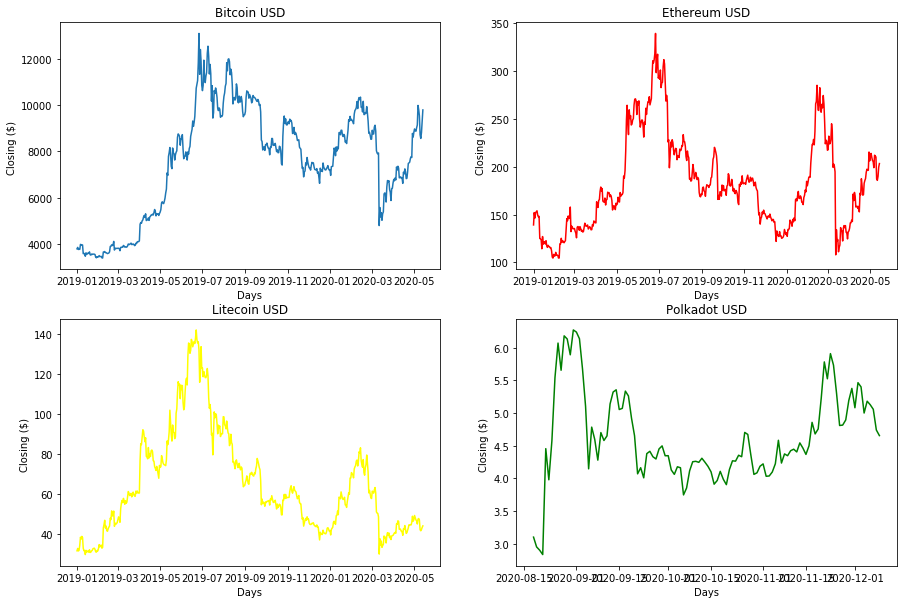

In [ ]:

fig,ax = plt.subplots(2,2,figsize=(15,10))
ax[0,0].plot(crypto[0].close)
ax[0,0].set_title('Bitcoin USD')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Closing ($) ')


ax[0,1].plot(crypto[1].close,color='red')
ax[0,1].set_title('Ethereum USD')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Closing ($) ')

ax[1,0].plot(crypto[2].close, color='yellow')
ax[1,0].set_title('Litecoin USD')
ax[1,0].set_xlabel('Days')
ax[1,0].set_ylabel('Closing ($) ')

ax[1,1].plot(crypto[3].close, color='green')
ax[1,1].set_title('Polkadot USD')
ax[1,1].set_xlabel('Days')
ax[1,1].set_ylabel('Closing ($) ')

In [ ]:
SEQ_LN = 60

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(crypto[0])

In [ ]:
scaled_data.shape

(500, 1)

In [ ]:
train_ratio = 0.65
train_size = int(len(scaled_data)*train_ratio)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size,:]
test_data = scaled_data[train_size:-1,:]

In [ ]:
train_data.shape , test_data.shape

((325, 1), (174, 1))

In [ ]:
def create_seq(data,slen):
  dataX,dataY=[],[]
  for i in range(len(data)-slen-1):
    dataX.append(data[i:i+slen,0])
    dataY.append(data[i+slen,0])
  return np.array(dataX),np.array(dataY)
Xtrain,Ytrain = create_seq(train_data,SEQ_LN)
Xtest,Ytest = create_seq(test_data,SEQ_LN)
print(Xtrain.shape,Ytrain.shape)
  

(264, 60) (264,)


In [ ]:
Xtrain=Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1],1))
Xtest=Xtest.reshape((Xtest.shape[0],Xtest.shape[1],1))
print(Xtrain.shape,Xtest.shape)

(264, 60, 1) (113, 60, 1)


In [ ]:
model=Sequential()
model = Sequential()
model.add(LSTM(128, input_shape=(Xtrain.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 128)           512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)              

In [ ]:
model_name = 'BITCOIN_model'
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f"bitcoin_model.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True,)
logs = tf.keras.callbacks.CSVLogger(filename=f"bitcoin_model.csv")

In [ ]:
model.fit(Xtrain,Ytrain,validation_data=(Xtest,Ytest),epochs=100,batch_size=64,verbose=1,callbacks=[logs])

Epoch 1/100
5/5 [==============================] - 3s 575ms/step - loss: 1.9830 - accuracy: 0.0000e+00 - val_loss: 0.2074 - val_accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 2s 303ms/step - loss: 0.7882 - accuracy: 0.0000e+00 - val_loss: 0.1533 - val_accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 1s 292ms/step - loss: 0.5152 - accuracy: 0.0038 - val_loss: 0.1451 - val_accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 1s 286ms/step - loss: 0.5201 - accuracy: 0.0038 - val_loss: 0.1303 - val_accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 1s 287ms/step - loss: 0.5616 - accuracy: 0.0000e+00 - val_loss: 0.1051 - val_accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 1s 290ms/step - loss: 0.4340 - accuracy: 0.0038 - val_loss: 0.1211 - val_accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 1s 291ms/step - loss: 0.4531 - accuracy: 0.0000e+00 - val_loss: 0.1

Text(0.5, 1.0, 'Loss')

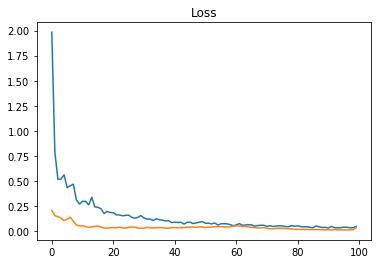

In [ ]:

history = pd.read_csv(f"bitcoin_model.csv")
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

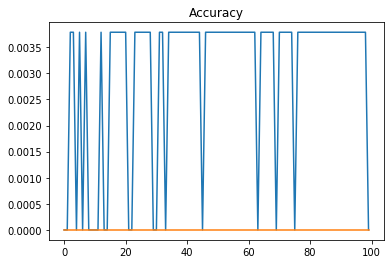

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')

In [ ]:
train_predict=model.predict(Xtrain)
test_predict=model.predict(Xtest)

train_predict=sc.inverse_transform(train_predict)
test_predict=sc.inverse_transform(test_predict)

In [ ]:

print("Train MSE: ",math.sqrt(mean_squared_error(Ytrain,train_predict)))
print("Test MSE: ",math.sqrt(mean_squared_error(Ytest,test_predict)))

Train MSE:  6828.817365404425
Test MSE:  6952.188785968457


##Result

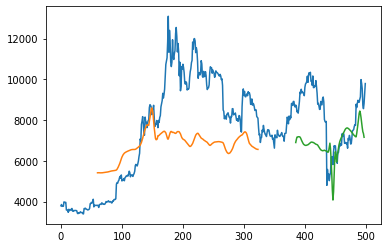

In [ ]:

look_back=60
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(scaled_data)-2, :] = test_predict
plt.plot(sc.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()